In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, timedelta

In [34]:
# Paths
yield_path = r".\data\yield\yield_spread_3mo_5yr.csv"
sentiment_dir = "sentiment_results"
file_map = {
    "fomc_minutes_analysis.csv": "Minutes",
    "press_conferences_analysis.csv": "Press Conference",
    "fed_speeches_analysis.csv": "Speech"
}

# Load yield data
yield_df = pd.read_csv(yield_path)
yield_df['Date'] = pd.to_datetime(yield_df['observation_date'])

# Define eras
def assign_period(date):
    if pd.Timestamp('2017-12-31') < date < pd.Timestamp('2020-01-01'):
        return "2018–2019"
    elif pd.Timestamp('2023-12-31') < date < pd.Timestamp('2026-01-01'):
        return "2024–2025"
    else:
        return "Other"
    
yield_df["Period"] = yield_df["Date"].apply(assign_period)

In [3]:
# Plot settings
sns.set(style="whitegrid", context="notebook", font_scale=1.1)

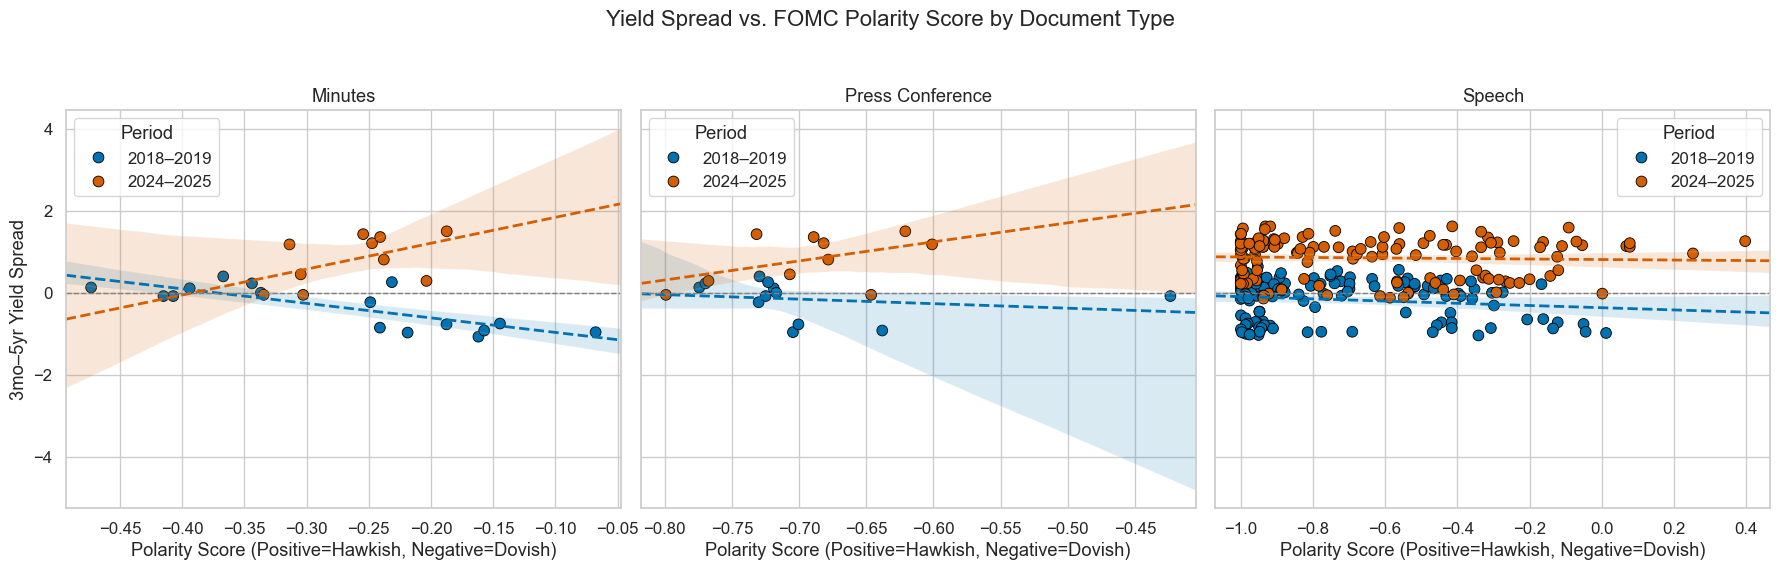

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (filename, doc_type) in zip(axes, file_map.items()):
    sentiment_path = os.path.join(sentiment_dir, filename)
    sentiment_df = pd.read_csv(sentiment_path)
    sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])
    
    # Merge with yield spread
    merged_df = pd.merge(sentiment_df, yield_df, on="Date", how="inner")

    # Filter valid time periods only
    merged_df = merged_df[merged_df["Period"].isin(["2018–2019", "2024–2025"])]

    # Plot
    sns.scatterplot(
        data=merged_df,
        x="Polarity Score",
        y="SPREAD_3MO_5YR",
        hue="Period",
        palette={"2018–2019": "#0072B2", "2024–2025": "#D55E00"},
        ax=ax,
        s=60,
        edgecolor="black"
    )

    # Add regression line for each period
    for period in ["2018–2019", "2024–2025"]:
        sub_df = merged_df[merged_df["Period"] == period]
        sns.regplot(
            data=sub_df,
            x="Polarity Score",
            y="SPREAD_3MO_5YR",
            scatter=False,
            ax=ax,
            color="#0072B2" if period == "2018–2019" else "#D55E00",
            truncate=False,
            line_kws={"linewidth": 2, "linestyle": "dashed"}
        )

    ax.set_title(f"{doc_type}")
    ax.set_xlabel("Polarity Score (Positive=Hawkish, Negative=Dovish)")
    ax.set_ylabel("3mo–5yr Yield Spread" if doc_type == "Minutes" else "")
    ax.axhline(0, linestyle="--", color="gray", linewidth=1)
    ax.legend(title="Period")

plt.suptitle("Yield Spread vs. FOMC Polarity Score by Document Type", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


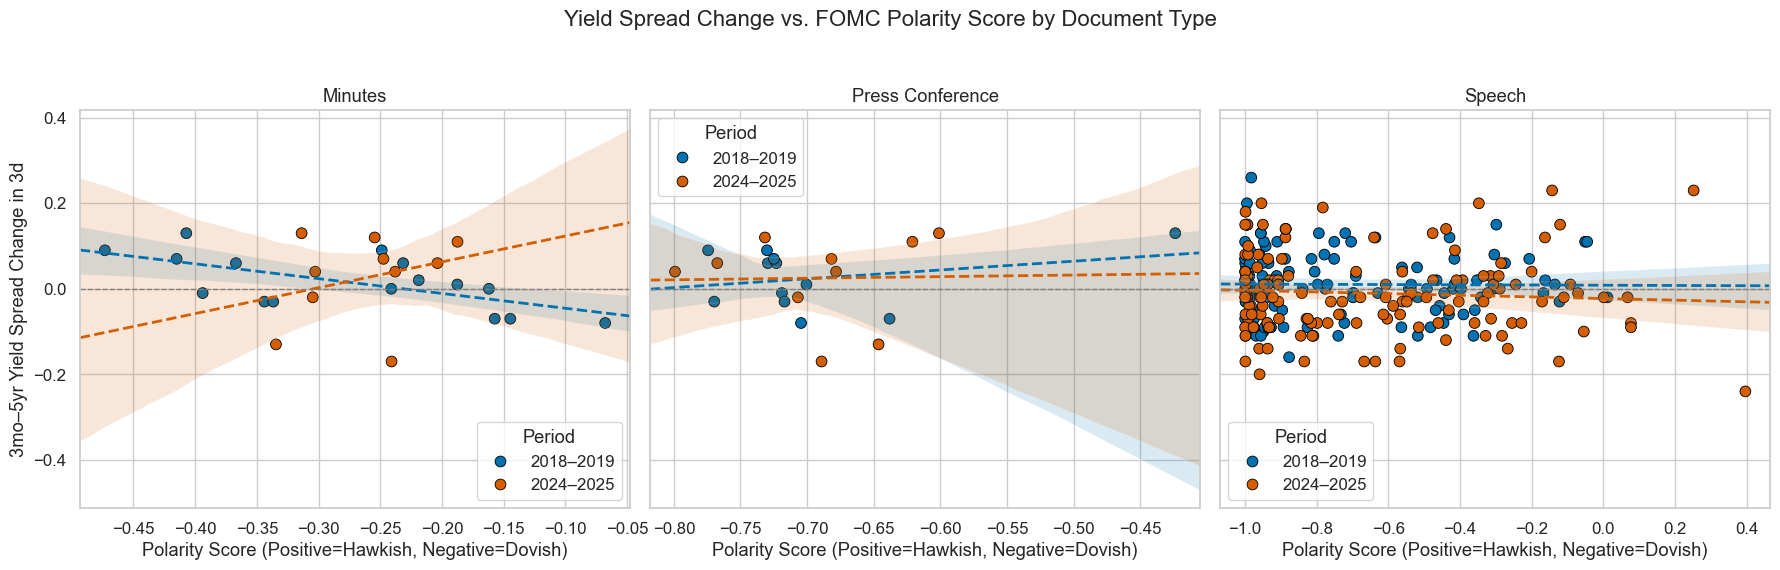

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (filename, doc_type) in zip(axes, file_map.items()):
    sentiment_path = os.path.join(sentiment_dir, filename)
    sentiment_df = pd.read_csv(sentiment_path)
    sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])
    
    # Merge with yield spread
    merged_df = pd.merge(sentiment_df, yield_df, on="Date", how="inner")

    # Filter valid time periods only
    merged_df = merged_df[merged_df["Period"].isin(["2018–2019", "2024–2025"])]

    # Plot
    sns.scatterplot(
        data=merged_df,
        x="Polarity Score",
        y="SPREAD_CHANGE_3D",
        hue="Period",
        palette={"2018–2019": "#0072B2", "2024–2025": "#D55E00"},
        ax=ax,
        s=60,
        edgecolor="black"
    )

    # Add regression line for each period
    for period in ["2018–2019", "2024–2025"]:
        sub_df = merged_df[merged_df["Period"] == period]
        sns.regplot(
            data=sub_df,
            x="Polarity Score",
            y="SPREAD_CHANGE_3D",
            scatter=False,
            ax=ax,
            color="#0072B2" if period == "2018–2019" else "#D55E00",
            truncate=False,
            line_kws={"linewidth": 2, "linestyle": "dashed"}
        )

    ax.set_title(f"{doc_type}")
    ax.set_xlabel("Polarity Score (Positive=Hawkish, Negative=Dovish)")
    ax.set_ylabel("3mo–5yr Yield Spread Change in 3d" if doc_type == "Minutes" else "")
    ax.axhline(0, linestyle="--", color="gray", linewidth=1)
    ax.legend(title="Period")

plt.suptitle("Yield Spread Change vs. FOMC Polarity Score by Document Type", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_46372\748047631.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # or use 'RdBu_r' / 'seismic' for strong contrast


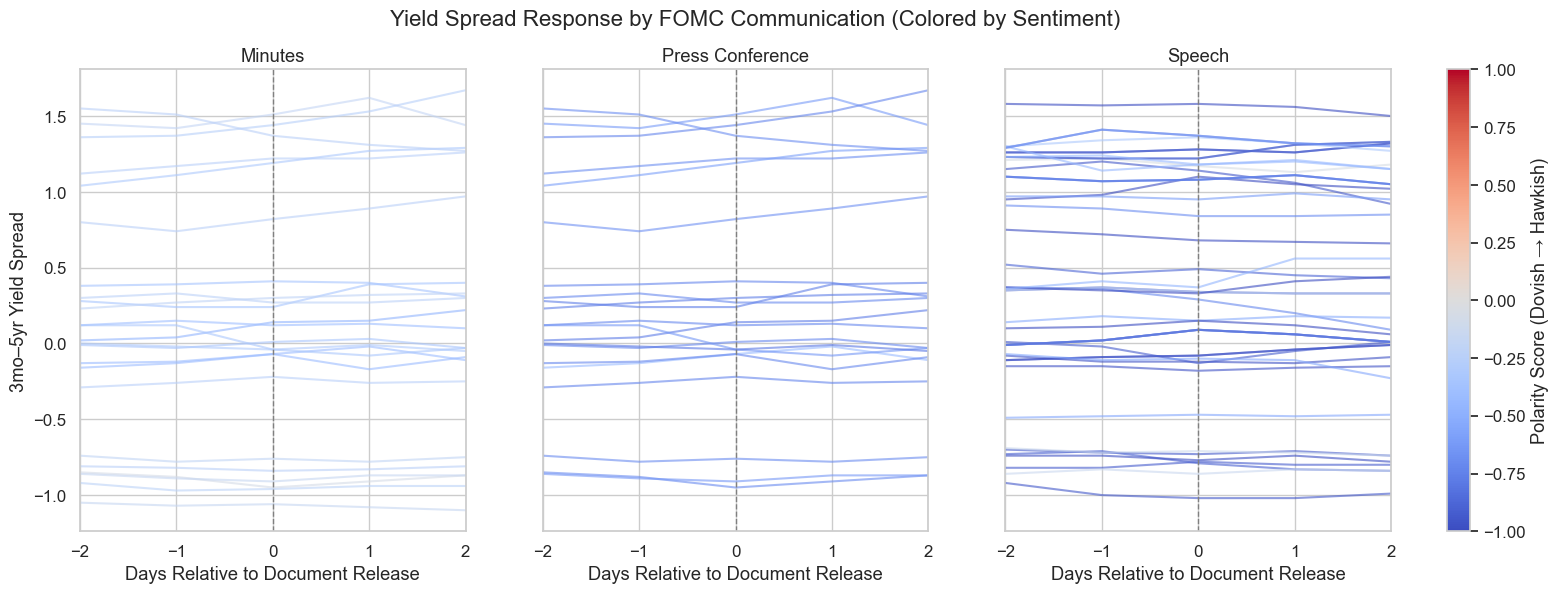

In [27]:
# Initialize figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Yield Spread Movement Around FOMC Events", fontsize=16)

# Set up colormap: diverging, centered at 0
norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cmap = cm.get_cmap('coolwarm')  # or use 'RdBu_r' / 'seismic' for strong contrast

for ax, (filename, doc_type) in zip(axes, file_map.items()):
    sentiment_path = os.path.join(sentiment_dir, filename)
    sent_df = pd.read_csv(sentiment_path)
    sent_df['Date'] = pd.to_datetime(sent_df['Date'])

    for _, row in sent_df.iterrows():
        event_date = row['Date']
        polarity = row['Polarity Score']
        color = cmap(norm(polarity))  # continuous mapping

        window = yield_df[
            (yield_df['Date'] >= event_date - pd.Timedelta(days=2)) &
            (yield_df['Date'] <= event_date + pd.Timedelta(days=2))
        ].copy()

        if len(window) == 5:
            window['Day'] = (window['Date'] - event_date).dt.days
            ax.plot(window['Day'], window['SPREAD_3MO_5YR'], color=color, alpha=0.6)

    ax.set_title(doc_type)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_xlim(-2, 2)
    ax.set_xlabel("Days Relative to Document Release")
    if ax is axes[0]:
        ax.set_ylabel("3mo–5yr Yield Spread")

# Add a colorbar to indicate polarity score
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Polarity Score (Dovish → Hawkish)")

fig.suptitle("Yield Spread Response by FOMC Communication (Colored by Sentiment)", fontsize=16)
plt.show()

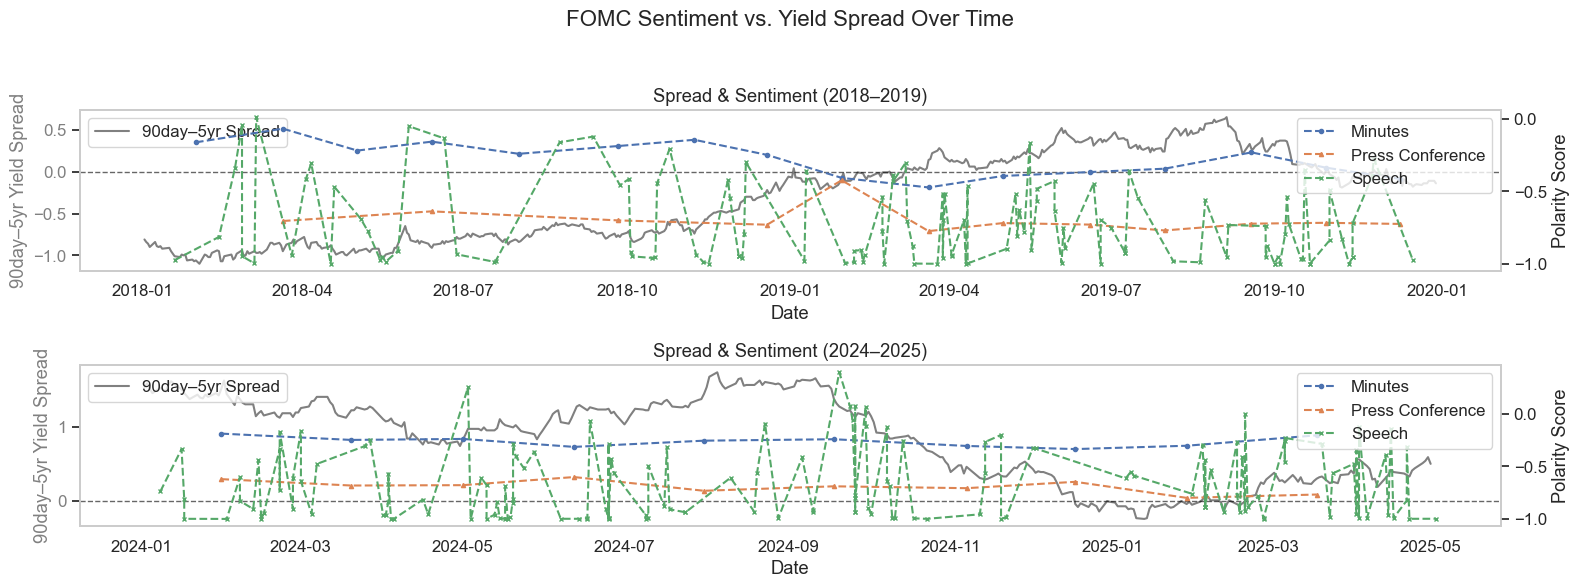

In [50]:
file_map = {
    "fomc_minutes_analysis.csv": ("Minutes", "o"),
    "press_conferences_analysis.csv": ("Press Conference", "^"),
    "fed_speeches_analysis.csv": ("Speech", "x")
}

# Load and preprocess yield data
yield_df = pd.read_csv(yield_path)
yield_df['Date'] = pd.to_datetime(yield_df['observation_date'])
yield_df = yield_df[["Date", "SPREAD_3MO_5YR"]]

# Define periods
periods = {
    "2018–2019": (pd.Timestamp("2018-01-01"), pd.Timestamp("2019-12-31")),
    "2024–2025": (pd.Timestamp("2024-01-01"), pd.Timestamp("2025-12-31")),
}

# Prepare sentiment data
sentiment_data = {}
for filename, (label, marker) in file_map.items():
    df = pd.read_csv(os.path.join(sentiment_dir, filename))
    df["Date"] = pd.to_datetime(df["Date"])
    df["Type"] = label
    df["Marker"] = marker
    sentiment_data[label] = df

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharey=False)

for ax, (period_name, (start_date, end_date)) in zip(axes, periods.items()):
    # Filter yield data
    yld = yield_df[(yield_df["Date"] >= start_date) & (yield_df["Date"] <= end_date)]

    # Plot yield spread (solid gray line)
    ax.plot(yld["Date"], yld["SPREAD_3MO_5YR"], color="gray", label="90day–5yr Spread")

    # Twin axis for sentiment
    ax2 = ax.twinx()

    for label, df in sentiment_data.items():
        df_period = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)].sort_values("Date")
        df_period = df_period.dropna(subset=["Polarity Score", "Date"])  # ← add this line
        ax2.plot(
            df_period["Date"],
            df_period["Polarity Score"],
            marker=df_period["Marker"].iloc[0],
            linestyle="--",
            markersize=3,
            label=label
        )

    ax.set_title(f"Spread & Sentiment ({period_name})")
    ax.set_xlabel("Date")
    ax.set_ylabel("90day–5yr Yield Spread", color="gray")
    ax.tick_params(axis='y', labelcolor="gray")
    ax2.set_ylabel("Polarity Score")

    # Legends
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

    ax.grid(False)
    ax2.grid(False)

    # Add baseline at y=0 only on the main ax
    ax.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.6)

# Layout and show
fig.suptitle("FOMC Sentiment vs. Yield Spread Over Time", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()